> This model combiles two branches: MobileNetV2 and Bidirectional LSTM, Inspired by this paper here: https://arxiv.org/abs/1804.01401
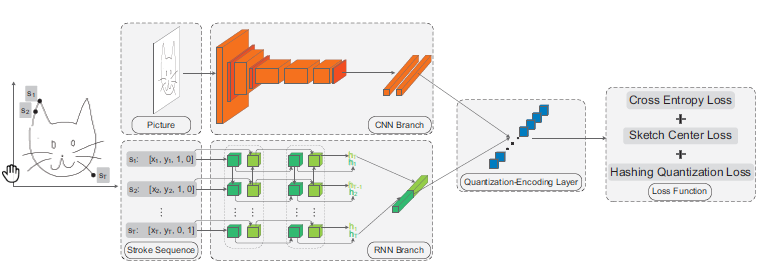
# Data Description
- The Quick Draw Dataset is a collection of millions of drawings across 300+ categories, contributed by players of Quick, Draw! The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.

- Your models should predict the correct "word" of the drawing. 
- You may predict up to 3 guesses per drawing.

In [2]:
#########################
# Setup & Configuration  
#######################
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import os, gc, ast, cv2
from ast import literal_eval
gc.enable()

import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional
from keras.layers import Flatten, Dense, concatenate
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.applications import MobileNet, MobileNetV2
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.sequence import pad_sequences

from keras.layers import CuDNNLSTM as LSTM  # 3x faster on GPU instances
start = dt.datetime.now()

In [3]:
#####################
# Global Constants
##################
DP_DIR = '../input/shuffle-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'

BASE_SIZE = 256
NCSVS = 100 # Shuffled CSVs
NCATS = 340 # Classes

STEPS = 800 #1000
EPOCHS = 4 #* 3 ###30
size =  128 ###80
batchsize = 340  ###530

np.random.seed(seed=100)
tf.set_random_seed(seed=100)

def f2cat(filename: str) -> str: return filename.split('.')[0]
def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [4]:
###########
# Metrics
#########
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# MobileNet Branch
MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks
- [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)
- [MobileNet version 2](http://machinethink.net/blog/mobilenet-v2/)
- [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5)
- [MobileNetV2: The Next Generation of On-Device Computer Vision Networks](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html)


In [5]:
base_model = MobileNet( ###
    input_shape=(size, size, 3),  ###
    alpha=1.,
    weights="imagenet",
    include_top = False  ###
)

inputLayer = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(NCATS, activation='softmax')(x)

model = Model(inputLayer, x)
base_model = Sequential(model.layers[:-2]) ###Corrected
#base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step


# LSTM Branch

In [6]:
inputLayer = Input(shape=(70, 3))
x = BatchNormalization()(inputLayer)
x = Conv1D(256, (5,), activation="relu")(x)
x = Dropout(0.2)(x)
x = Conv1D(256, (5,), activation="relu")(x)
x = Dropout(0.2)(x)
x = Conv1D(256, (3,), activation="relu")(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(NCATS, activation='softmax')(x)
stroke_read_model = Model(inputLayer, x)

stroke_read_model.compile(
    optimizer = Adam(lr=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy', top_3_accuracy]
)
stroke_read_model = Sequential(stroke_read_model.layers[:-1])
#stroke_read_model.summary()

# Combining two branches

In [7]:
Input1 = base_model.input
y = base_model.output
y = GlobalAveragePooling2D()(y)

Input2 = Input(shape = (70, 3))
z = stroke_read_model(Input2)
x = concatenate([y, z])
x = Dropout(0.3)(x)
x = Dense(NCATS, activation='softmax')(x)

model = Model([Input1, Input2], x)
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy]
)

In [8]:
######################
# LSTM Preprocessing
####################
def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=70, 
                         padding='post').swapaxes(0, 1)

## Training with Image Generator

In [9]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing1'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing1.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = np.repeat(x, 3, axis =3)
                x = preprocess_input(x).astype(np.float32)
                
                df['drawing'] = df['drawing'].map(_stack_it)
                x2 = np.stack(df['drawing'], 0)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield [x, x2], y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing1'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    
    for i, raw_strokes in enumerate(df.drawing1.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = np.repeat(x, 3, axis =3)
    x = preprocess_input(x).astype(np.float32)
    df['drawing'] = df['drawing'].map(_stack_it)
    x2 = np.stack(df['drawing'], 0)
    return [x,x2]

In [10]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))
val_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1, NCSVS))

In [11]:
BestModelWeightsPath = './mobilenet_lstm.hdf5'
callbacks = [
    ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        factor=0.5, patience=3,
        min_delta=0.005, ###
        mode='max',
        cooldown=3,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10
    ),
    ModelCheckpoint(
        BestModelWeightsPath, monitor='val_top_3_accuracy', verbose=1, ####
        save_best_only=True, 
        save_weights_only=True,
        mode='max' ###
    )
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data = val_datagen,
    validation_steps = 100,  ###
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/4
800/800 [==============================] - 1072s 1s/step - loss: 1.8125 - categorical_crossentropy: 1.8125 - categorical_accuracy: 0.5693 - top_3_accuracy: 0.7612 - val_loss: 1.5294 - val_categorical_crossentropy: 1.5294 - val_categorical_accuracy: 0.6217 - val_top_3_accuracy: 0.8127

Epoch 00001: val_top_3_accuracy improved from -inf to 0.81274, saving model to ./mobilenet_lstm.hdf5
Epoch 2/4
800/800 [==============================] - 1059s 1s/step - loss: 1.2897 - categorical_crossentropy: 1.2897 - categorical_accuracy: 0.6770 - top_3_accuracy: 0.8525 - val_loss: 1.2619 - val_categorical_crossentropy: 1.2619 - val_categorical_accuracy: 0.6807 - val_top_3_accuracy: 0.8541

Epoch 00002: val_top_3_accuracy improved from 0.81274 to 0.85409, saving model to ./mobilenet_lstm.hdf5
Epoch 3/4
800/800 [==============================] - 1062s 1s/step - loss: 1.1886 - categorical_crossentropy: 1.1886 - categorical_accuracy: 0.6995 - top_3_accuracy: 0.8686 - val_loss: 1.1401 - val_categ

In [ ]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data = val_datagen,
    validation_steps = 100,  ###
    callbacks = callbacks
)
hists.append(hist)

In [ ]:
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data = val_datagen,
    validation_steps = 100,  ###
    callbacks = callbacks
)
hists.append(hist)

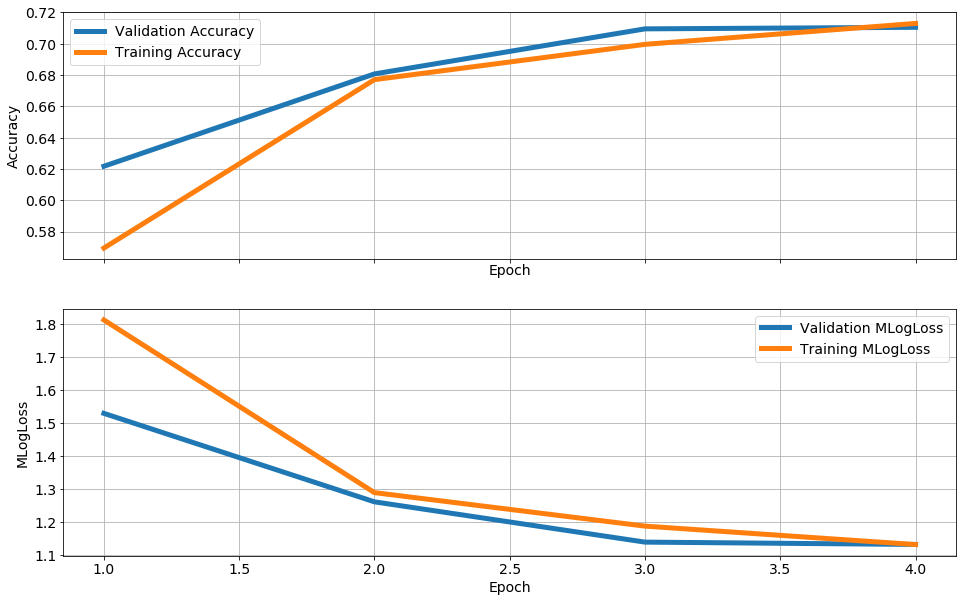

In [12]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [13]:
# Load Best model weights
model.load_weights(BestModelWeightsPath)
df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS-1)), nrows=34000)
for i in range(10):
    valid_df = df.loc[i*3400:(i+1)*3400,:].copy()
    x_valid, x2 = df_to_image_array_xd(valid_df, size)
    y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
    print(x_valid.shape, y_valid.shape)
    print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))
    valid_predictions = model.predict([x_valid, x2], batch_size=128, verbose=1)
    map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)

    print('Map3: {:.3f}'.format(map3))

(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 6s 2ms/step
Map3: 0.781
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.789
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.791
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.783
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.790
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.786
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/3401 [==============================] - 4s 1ms/step
Map3: 0.778
(3401, 128, 128, 3) (3401, 340)
Validation array memory 0.62 GB
3401/

## Create Submission

In [14]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))

for i in range(10):
    end = min((i+1)*11220, 112199)
    subtest= test.iloc[i*11220:end].copy().reset_index(drop=True)
    x_test = df_to_image_array_xd(subtest, size)

    test_predictions = model.predict(x_test, batch_size=128, verbose=1)

    top3 = preds2catids(test_predictions)
    cats = list_all_categories()
    id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
    top3cats = top3.replace(id2cat)
    subtest['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
    subtest.head()
    if i ==0:
        submission = subtest[['key_id', 'word']]
    else: 
        submission = submission.append(subtest[['key_id', 'word']], ignore_index=True)

11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9000003627287624,DE,"[[17, 117, 2], [18, 176, 1], [20, 184, 1], [25...","[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25...",radio stereo snorkel
1,9000010688666847,UA,"[[174, 3, 2], [145, 0, 1], [106, 7, 1], [38, 1...","[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16...",hockey_puck bottlecap hot_dog
2,9000023642890129,BG,"[[0, 135, 2], [12, 90, 1], [14, 45, 1], [17, 3...","[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ...",castle The_Great_Wall_of_China fence
3,9000038588854897,US,"[[0, 243, 2], [9, 233, 1], [23, 201, 1], [40, ...","[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20...",mountain rainbow tent
4,9000052667981386,AR,"[[87, 220, 2], [82, 218, 1], [71, 201, 1], [63...","[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,...",fireplace campfire leaf


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9100920580473785,GB,"[[0, 255, 2], [23, 215, 1], [60, 125, 1], [72,...","[[[0, 23, 60, 72, 72, 77], [255, 215, 125, 75,...",The_Eiffel_Tower lighthouse mountain
1,9100926486991295,DE,"[[84, 246, 2], [74, 252, 1], [51, 253, 1], [33...","[[[84, 74, 51, 33, 30, 31, 33, 43, 44, 42, 29,...",paintbrush fork broccoli
2,9100937669426116,US,"[[114, 15, 2], [155, 3, 1], [178, 0, 1], [215,...","[[[114, 155, 178, 215, 237, 248, 255, 252, 244...",pool brain steak
3,9100955648707292,US,"[[0, 135, 2], [0, 85, 1], [8, 44, 1], [8, 24, ...","[[[0, 0, 8, 8, 5, 15, 40, 76, 80, 73, 74], [13...",lighthouse diving_board fire_hydrant
4,9100965440303543,CA,"[[110, 174, 2], [110, 174, 1], [110, 174, 2], ...","[[[110, 110], [174, 174]], [[110, 110], [174, ...",cello violin guitar


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9200307425971918,RO,"[[186, 219, 1], [175, 210, 1], [164, 205, 1], ...","[[[17, 11, 10, 22, 49, 53, 60, 56, 32], [220, ...",campfire fireplace grapes
1,9200311604684489,ID,"[[52, 48, 2], [50, 110, 1], [43, 154, 1], [95,...","[[[52, 50, 43, 95, 125, 164, 217, 237, 244, 23...",calendar cooler garden
2,9200322542609219,AU,"[[26, 84, 2], [24, 112, 1], [5, 193, 1], [1, 2...","[[[26, 24, 5, 1, 61, 59, 62, 77, 91, 87, 74, 1...",candle lipstick marker
3,9200324540328674,KR,"[[2, 40, 2], [115, 35, 1], [108, 47, 1], [86, ...","[[[2, 115, 108, 86, 10, 8, 18, 45, 104, 129], ...",crocodile raccoon sleeping_bag
4,9200329448114778,US,"[[49, 255, 2], [52, 233, 1], [51, 216, 1], [0,...","[[[49, 52, 51, 0, 0, 4, 23, 48], [255, 233, 21...",hand finger cactus


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9301551508425888,RU,"[[67, 18, 2], [59, 6, 1], [12, 31, 1], [19, 40...","[[[67, 59, 12, 19, 0, 11, 11, 31, 40, 76, 82, ...",sheep rhinoceros cow
1,9301558465894628,BR,"[[7, 220, 2], [4, 146, 1], [11, 137, 1], [43, ...","[[[7, 4, 11, 43, 136, 175, 183, 186, 177, 176,...",birthday_cake cake candle
2,9301586684400058,IN,"[[126, 13, 1], [187, 0, 1], [203, 0, 1], [245,...","[[[31, 116], [73, 82]], [[110, 145, 176, 201, ...",bulldozer firetruck binoculars
3,9301607648785195,RO,"[[13, 255, 2], [2, 197, 1], [0, 164, 1], [0, 1...","[[[13, 2, 0, 0, 6, 22, 35, 49, 65, 88, 96, 99,...",finger nail toe
4,9301639423065770,US,"[[0, 11, 2], [22, 1, 1], [50, 0, 1], [56, 7, 1...","[[[0, 22, 50, 56, 68, 72, 80, 97, 147, 176, 18...",roller_coaster squiggle garden_hose


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9400265523696481,US,"[[52, 0, 2], [58, 48, 1], [60, 150, 1], [12, 1...","[[[52, 58, 60], [0, 48, 150]], [[12, 51, 110, ...",shovel broom golf_club
1,9400265621525158,RS,"[[8, 112, 2], [33, 88, 1], [58, 74, 1], [93, 6...","[[[8, 33, 58, 93, 115, 125, 132, 147, 173, 183...",flamingo duck swan
2,9400275642474076,KR,"[[136, 0, 2], [113, 5, 1], [103, 4, 1], [56, 2...","[[[136, 113, 103, 56, 28, 5, 0, 2, 13, 35, 74,...",circle moon potato
3,9400279542649322,US,"[[117, 114, 2], [145, 51, 1], [173, 3, 1], [25...","[[[117, 145, 173], [114, 51, 3]], [[255, 202, ...",tent swing_set yoga
4,9400284608448631,GB,"[[61, 55, 2], [64, 57, 1], [61, 89, 1], [40, 1...","[[[61, 64, 61, 40, 27, 69, 117, 152, 167, 160,...",anvil underwear t-shirt


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9501258502135001,EC,"[[5, 1, 2], [42, 0, 1], [66, 6, 1], [113, 8, 1...","[[[5, 42, 66, 113, 132, 122, 118, 121, 124, 12...",passport book cup
1,9501262625745390,AU,"[[115, 77, 2], [115, 77, 1], [255, 8, 2], [239...","[[[115, 115], [77, 77]], [[255, 239, 211], [8,...",ocean river beach
2,9501270580648028,AR,"[[41, 6, 2], [73, 10, 1], [134, 5, 1], [206, 1...","[[[41, 73, 134, 206, 249], [6, 10, 5, 10, 6]],...",underwear piano shorts
3,9501277429376205,GB,"[[11, 21, 2], [60, 9, 1], [114, 5, 1], [71, 7,...","[[[11, 60, 114], [21, 9, 5]], [[71, 94, 126, 1...",river ocean line
4,9501282623040039,US,"[[223, 20, 2], [78, 23, 1], [0, 31, 1], [102, ...","[[[223, 78, 0, 102, 220, 229, 233, 241, 246, 2...",clarinet trombone trumpet


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9602596680078335,US,"[[75, 51, 2], [50, 59, 1], [43, 64, 1], [39, 7...","[[[75, 50, 43, 39, 42, 56, 68, 74], [51, 59, 6...",trombone trumpet clarinet
1,9602611623679549,US,"[[6, 6, 2], [6, 81, 1], [17, 117, 1], [25, 128...","[[[6, 6, 17, 25, 43, 65, 98, 119, 134, 137, 13...",stethoscope wine_glass necklace
2,9602612506186289,AU,"[[0, 238, 2], [17, 229, 1], [14, 239, 1], [14,...","[[[0, 17, 14], [238, 229, 239]], [[14, 25, 10]...",house cooler barn
3,9602619569040232,CA,"[[75, 183, 1], [77, 168, 1], [125, 140, 2], [1...","[[[135, 102, 109, 133, 140, 136], [116, 120, 1...",raccoon cat tiger
4,9602645540366675,US,"[[117, 0, 2], [97, 3, 1], [68, 19, 1], [36, 42...","[[[117, 97, 68, 36, 19, 5, 0, 2, 17, 52, 84, 1...",compass clock cookie


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9701275688837157,US,"[[0, 43, 2], [94, 41, 1], [108, 47, 1], [118, ...","[[[0, 94, 108, 118, 120, 112, 96, 39, 27, 22, ...",mailbox hammer nail
1,9701278540590933,AU,"[[125, 86, 1], [147, 79, 1], [169, 81, 1], [17...","[[[85, 73, 50, 31, 26, 27, 32, 42, 57, 78, 90,...",brain watermelon steak
2,9701283525722757,AU,"[[39, 81, 1], [133, 24, 2], [106, 28, 1], [18,...","[[[70, 109, 138, 153, 154, 152, 145], [130, 12...",snorkel snail monkey
3,9701283667185289,AU,"[[187, 28, 2], [119, 34, 1], [88, 40, 1], [79,...","[[[187, 119, 88, 79, 78, 86, 103, 162, 200, 23...",paper_clip trombone garden_hose
4,9701290529946375,VE,"[[168, 80, 1], [125, 94, 1], [108, 94, 1], [85...","[[[60, 61, 74, 103, 138, 163, 168, 125, 108, 8...",backpack owl elephant


11220/11220 [==============================] - 13s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9800537604091351,CA,"[[139, 0, 2], [94, 53, 1], [58, 72, 1], [55, 9...","[[[139, 94, 58, 55, 56, 48, 63, 73, 84, 84, 87...",leg knee hockey_stick
1,9800541602576875,US,"[[50, 166, 2], [67, 251, 1], [135, 161, 2], [1...","[[[50, 67], [166, 251]], [[135, 116, 114, 94, ...",broccoli tree cactus
2,9800544525994931,TH,"[[50, 30, 2], [30, 62, 1], [0, 88, 1], [10, 89...","[[[50, 30, 0, 10, 141, 235, 239, 245, 169, 61,...",washing_machine dishwasher cooler
3,9800545661480105,AT,"[[45, 11, 2], [50, 13, 1], [82, 13, 1], [141, ...","[[[45, 50, 82, 141, 253, 255, 243, 233, 229, 2...",postcard passport book
4,9800549548916701,US,"[[131, 142, 1], [131, 174, 1], [181, 176, 1], ...","[[[145, 143, 131, 131, 181, 231, 237, 242, 242...",fire_hydrant lantern lighthouse


11219/11219 [==============================] - 14s 1ms/step


,key_id,countrycode,drawing,drawing1,word
0,9900095686132860,US,"[[183, 27, 2], [109, 39, 1], [20, 59, 1], [3, ...","[[[183, 109, 20, 3, 0, 6, 20, 52, 195, 247, 25...",flying_saucer hat hot_dog
1,9900104667719043,US,"[[83, 22, 2], [44, 22, 1], [27, 26, 1], [12, 3...","[[[83, 44, 27, 12, 3, 0, 2, 8, 25, 55, 83, 115...",pond pool watermelon
2,9900115400804942,IN,"[[70, 32, 1], [80, 41, 1], [83, 49, 1], [76, 5...","[[[7, 244], [5, 0]], [[15, 8, 2, 2, 17, 23, 92...",keyboard calendar dresser
3,9900115604640971,GR,"[[172, 54, 2], [145, 48, 1], [86, 47, 1], [70,...","[[[172, 145, 86, 70, 46, 45, 69, 90, 135, 201,...",steak flying_saucer hockey_puck
4,9900116684085288,US,"[[23, 90, 2], [38, 154, 1], [35, 228, 1], [39,...","[[[23, 38, 35, 39, 63, 79, 112, 131, 156, 164,...",mug coffee_cup cup


In [15]:
submission.to_csv('lstm_mobilenet.csv', index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo snorkel
1,9000010688666847,hockey_puck bottlecap hot_dog
2,9000023642890129,castle The_Great_Wall_of_China fence
3,9000038588854897,mountain rainbow tent
4,9000052667981386,fireplace campfire leaf


(112199, 2)

In [16]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2018-12-03 20:56:20.213036.
Total time 4741s


## Comments:
- Native keras doesn't go well with tf.keras, so import everything of keras ..do not mix up tensorflow.
- Sometimes very nice ideas are wasted, bacause we build them on false things.